# Deloitte Challenge - supermarket power consumption optimisation

Running mall depends on the power in the below order of precendence.<br>
<br>Consumption <br>
1. Mall usage<br>
2. Charging power<br>

Production <br>
1. Solar power<br>
2. discharging power<br>
3. plug power<br>

# Idea: <br>
1) We are iterate based on 30 mins interval<br>
2) for each interval compute the below items <br>
3) classically compute the mall consumption <br>
4) classically compute the solar power based on the weather data <br>
5) classically pick the vehicles for discharging and charging for that interval. <br>
   i) discharging cars are based on the arrival time <br>
   ii) charging cars are based on the departure time minus 30 mins(charging/discharging rate)<br>
   iii) if arrival time and departure time are same, we are going to skip those vehicles due to no time to charge and discharge<br>
   iv) if arrival time and deparute time have only 30 mins difference, then we can either charge or discharge.<br>
   v) In case of iv), if arrival battery is greater than departure battery, then discharge<br>
   vi) In case of iv), if arrival battery is lesser than departure battery, then charge <br>
6) based on step 5) all the charging vehicles are mandatorily charged, so the charging power is also calculated <br>
7) now mall consumption and vehicle charging can be met by solar power and exisitng mall battery value itself <br>
8) suppose if energy demand is not met, then we go for discharging power.<br>
9) discharging power is done by QUBO optmization on disharging vehicles to meet the remaining energy needed.<br>
10) if still energy demand is not met, then plug power is obtained<br>

# Read the data from csv
This is below to open the data files.<br>
use the car data from the github.<br>
The car data has 2 additional columns discharge ind and charging ind.<br>
the indicators are by default as N<br>
The algorithm if discharges the car, marks the discharge ind as D and after charging , it marks the charging ind as C <br>

In [1]:
import csv
car_csv = open('D:\DeloiteProject\ProjectGIT\Qustomers-main\Qustomers-main\data\car.csv')
#type(car_csv)
weather_csv = open('D:\DeloiteProject\ProjectGIT\Qustomers-main\Qustomers-main\data\weather.csv')
#type(weather_csv)

In [2]:
csvreader_car = csv.reader(car_csv)
csvreader_weather = csv.reader(weather_csv)

In [3]:
car_header = []
car_header = next(csvreader_car)
car_header

['Car',
 'Day',
 'Arrival Time',
 'Arrival Battery in %',
 'Depature Time (End of Slot)',
 'Minimal Depature Battery in %',
 'Discharging Ind',
 'Charging Ind']

In [4]:
car_data = []
for row in csvreader_car:
        car_data.append(row)
#car_data

In [5]:
weather_header = []
weather_header = next(csvreader_weather)
weather_header

['Monday',
 'Mon_weather',
 'Tuesday',
 'Tue_weather',
 'Wednesday',
 'Wed_weather',
 'Thursday',
 'Thu_weather',
 'Friday',
 'Fri_weather',
 'Saturday',
 'Sat_weather',
 'Sunday',
 'Sun_weather']

In [6]:
weather_data = []
for row in csvreader_weather:
        weather_data.append(row)
#weather_data

In [7]:
#Please run this only when you need to flush the data and prepare new data set
# car_csv.close()
# weather_csv.close()

# Declare the constants required for the processing

In [8]:
days=7#no of days in a week
days_List=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_intervals=48#no of 30 min intervals in a day
active_interval_start=16#active time starts by 8 am
active_interval_ends=44#active time ends by 10 pm
no_of_days_in_week=7
weekday_start=0#Monday
weekday_end=5#Saturday and 6 is Sunday
weekend=6

#mall consumption levels
rest_hrs_energy_KWh=12#24KWh per rest hour, so 12KWh for 30 mins
active_hrs_energy_KWh=60#120KWh per active hour, so 60KWh for 30 mins

#solar power production data
sunnyEnergy_KWh=90#180KWh per hour, so 90 for 30 mins
cloudyEnergy_KWh=40#80KWh per hour, so 40 for 30 mins
rainyEnergy_KWh=25#50KWh per hour, so 25 for 30 mins
nightEnergy_KWh=0

#mallBatteryCapacity
mallBatteryCapacity_KWh=250#500KWh per hour, so 250 for 30 mins

#carbon cost g/KWh
plugPowerCarbonCost=420
vehicleDischargingCarbonCost=84
vehicleChargingCarbonCost=-84

# Function to convert the time into timeindexes -> every 30 mins is represented by time index incremented from 0-47

In [9]:
def getTimeIndex(time):
#     print(time)
    time_arr=time.split(':')
    time_index=0
    for i in range(len(time_arr)):
        if time_arr[i]=='30':
            time_index=time_index+1
        else:
            time_index=time_index+(int(time_arr[i])*2)
    return time_index

# Function to convert the timeindexes to time -> every index represented by time. Eg: 3 is represented by 1:30 am and 0 is represented by 00:00 am

In [10]:
import math
def getTimeinHrMins(time):
    hr='00'
    if time>1:
        hr=str(math.ceil((time-1)/2))
    minute='00'
    if time%2==1:
        minute= '30'
    return hr+':'+ minute

# Function to convert the day to day index. Eg: Monday is represented by 0

In [11]:
def getDayIndex(day):
    if day=='Monday':
        return 0
    elif day=='Tuesday':
        return 1
    elif day=='Wednesday':
        return 2
    elif day=='Thursday':
        return 3
    elif day=='Friday':
        return 4
    elif day=='Saturday':
        return 5
    return 6

# Function to get mall consumption based on the time interval
active hours and rest hours ahve different values

In [12]:
def getMallConsumption(timeIndex, day):
    if day >=weekday_start and day <=weekday_end and timeIndex>=active_interval_start and timeIndex<=active_interval_ends:
        return active_hrs_energy_KWh
    elif day >=weekday_start and day <=weekday_end and (timeIndex<=active_interval_start or timeIndex>=active_interval_ends):
        return rest_hrs_energy_KWh
    elif day == weekend:
        return rest_hrs_energy_KWh
    return 0        

# Function to get the solar power calculated based on the weather data.
Input is the timeindex and dayindex

In [13]:
def getSolarPowerEnergy(timeIndex, day):
    if weather_data[timeIndex][(day*2)+1]=='Night':
        return nightEnergy_KWh
    elif weather_data[timeIndex][(day*2)+1]=='Cloudy':
        return cloudyEnergy_KWh
    elif weather_data[timeIndex][(day*2)+1]=='Rain':
        return rainyEnergy_KWh
    elif weather_data[timeIndex][(day*2)+1]=='Sun':
        return sunnyEnergy_KWh
    return nightEnergy_KWh

# Function to get the eligible discharging and charging vehicles
Discharging : <br>
    1) the arrival time should match the time index and day<br>
    2) the discharging indicator should be N<br>
    3) the time index should be minimum  1 hr before the departure time for full battery discharge<br>
    4) if the time between arrival and departure is 30 mins and the arrival battery is more than departure battery, then the difference in battery is discharged<br>

Charging : <br>
    1) the time index should be 30 mins before the departure time and day<br>
    2) the vehicle charging indicator should be N<br>
    3) if the time difference between the arrival time and departure time is 30 mins, then if the departure battery is lower than the arrival battery, then it is eligible for charging<br>

inputs are timeindex and day <br>
outputs are elegibleVehicleData: array <br>
    elegibleVehicleData[elegibleDischargingVehicle:array, elegibleDischargingVehicle_Factor:array, elegibleDischargingVehicleRealIndex:array, elegibleChargingVehicle:array, elegibleChargingVehicle_Factor:array, elegibleChargingVehicleRealIndex:array]<br>

elegibleDischargingVehicle -> array to store the eligible discharging vehicles <br>
elegibleDischargingVehicle_Factor -> array to store the arrival battery percentage, follows same order as elegibleDischargingVehicle<br>
elegibleDischargingVehicleRealIndex -> array to store the index of the vehicle in car_Data array, follows same order as elegibleDischargingVehicle<br>
elegibleChargingVehicle -> array to store the eligible charging vehicles <br>
elegibleDischargingVehicle_Factor -> array to store the departure battery percentage, follows same order as elegibleChargingVehicle<br>
elegibleChargingVehicleRealIndex -> array to store the index of the vehicle in car_Data array, follows same order as elegibleChargingVehicle<br>
<br>
  <br>
So, this way of picking the vehicles is similar to the time integral way of the other group. <br>

In [14]:
#compute Electric Vehicle charging/Discharging
#maximize Discharging
#minimize Charging - but mandatorily charge the discharged vehicles
#function to return the eligible vehicle list
import math
from sympy import Symbol, Integer, Pow, symbols, expand
from matplotlib import pyplot
import numpy

import neal

def getEligibleVehicles(timeindex, day):
    elegibleVehicleData=[]
    elegibleDischargingVehicle=[]
    elegibleDischargingVehicle_Factor=[]
    elegibleDischargingVehicleRealIndex=[]
    elegibleChargingVehicle=[]
    elegibleChargingVehicle_Factor=[]
    elegibleChargingVehicleRealIndex=[]
    for vehicleinfo in range(len(car_data)):
       
        #discharging qubo
        if car_data[vehicleinfo][2]!='' and getTimeIndex(car_data[vehicleinfo][2])<=timeindex and getDayIndex(car_data[vehicleinfo][1])==day and car_data[vehicleinfo][6]=='N':
            if (getTimeIndex(car_data[vehicleinfo][4])-getTimeIndex(car_data[vehicleinfo][2]))>1 and timeindex<=getTimeIndex(car_data[vehicleinfo][4])-2 :
                elegibleDischargingVehicle.append(car_data[vehicleinfo][0])
                elegibleDischargingVehicle_Factor.append(-math.ceil(float(car_data[vehicleinfo][3])*0.6))
                elegibleDischargingVehicleRealIndex.append(vehicleinfo)
                    
            if (getTimeIndex(car_data[vehicleinfo][4])-getTimeIndex(car_data[vehicleinfo][2]))==1 and int(car_data[vehicleinfo][3])>int(car_data[vehicleinfo][5]) and timeindex<=getTimeIndex(car_data[vehicleinfo][4])-1:
                elegibleDischargingVehicle.append(car_data[vehicleinfo][0])
                elegibleDischargingVehicle_Factor.append(-math.ceil(float(int(car_data[vehicleinfo][3])-int(car_data[vehicleinfo][5]))*0.6))
                elegibleDischargingVehicleRealIndex.append(vehicleinfo)
        
        #charging qubo
        if car_data[vehicleinfo][4]!='' and getTimeIndex(car_data[vehicleinfo][4])==timeindex+1 and getDayIndex(car_data[vehicleinfo][1])==day:
            if (getTimeIndex(car_data[vehicleinfo][4])-getTimeIndex(car_data[vehicleinfo][2]))>1 and car_data[vehicleinfo][6]=='D':
                elegibleChargingVehicle.append(car_data[vehicleinfo][0])
                elegibleChargingVehicle_Factor.append(math.ceil(float(car_data[vehicleinfo][5])*0.6))
                elegibleChargingVehicleRealIndex.append(vehicleinfo)
                    
            if (getTimeIndex(car_data[vehicleinfo][4])-getTimeIndex(car_data[vehicleinfo][2]))==1 and int(car_data[vehicleinfo][3])<int(car_data[vehicleinfo][5]):
                elegibleChargingVehicle.append(car_data[vehicleinfo][0])
                elegibleChargingVehicle_Factor.append(math.ceil(float(int(car_data[vehicleinfo][5])-int(car_data[vehicleinfo][3]))*0.6))
                elegibleChargingVehicleRealIndex.append(vehicleinfo)
                
    elegibleVehicleData.append(elegibleDischargingVehicle)
    elegibleVehicleData.append(elegibleDischargingVehicle_Factor)
    elegibleVehicleData.append(elegibleDischargingVehicleRealIndex)
    elegibleVehicleData.append(elegibleChargingVehicle)
    elegibleVehicleData.append(elegibleChargingVehicle_Factor)
    elegibleVehicleData.append(elegibleChargingVehicleRealIndex)
    return elegibleVehicleData

# Function computeVehicleDischargingEnergy is to optimise the discharging vehicles. <br>
It uses qubo to contruct the objective function. <br>
function has input as discharging vehicle data and the energy needed to discahrge from them. <br>
Eg: problem is to choose from the vehicles of below energies so that the total is 50W.<br>
vehicle V1 = 10W<br>
vehicle V2 = 25W<br>
vehicle V3 = 15W<br>
vehicle V4 = 20W<br>

So our qubo function should ensure we get {V1,V2,V3} or {V2,V4} or {V1,V3,V4}<br>

objective function is 10V1 + 25V2 + 15V3 + 20V4 = 50<br>
10V1 + 25V2 + 15V3 + 20V4 - 50 = 0<br>
Now, we will convert this into quadratic function<br>
(10V1 + 25V2 + 15V3 + 20V4 - 50)^2 = 0<br>
100V1^2 + 625V2^2 + 15V3^2 + 400V4^2 + 2500 -500V1 -1250V2 - 300V3 - 1000V4 + V1V2 + V1V3 + V1V4 + V2V3 + V2V4 + V3V4 = 0<br>

In Binary qubo, we have two solutions {0,1}, so the square of the value is again {0,1}<br>

So, reducing we get terms in linear sum of V1, V2, V3, V4 and quadratic combination of V1V2, V1V3, V1V4, V2V3, V2V4, V3V4<br>

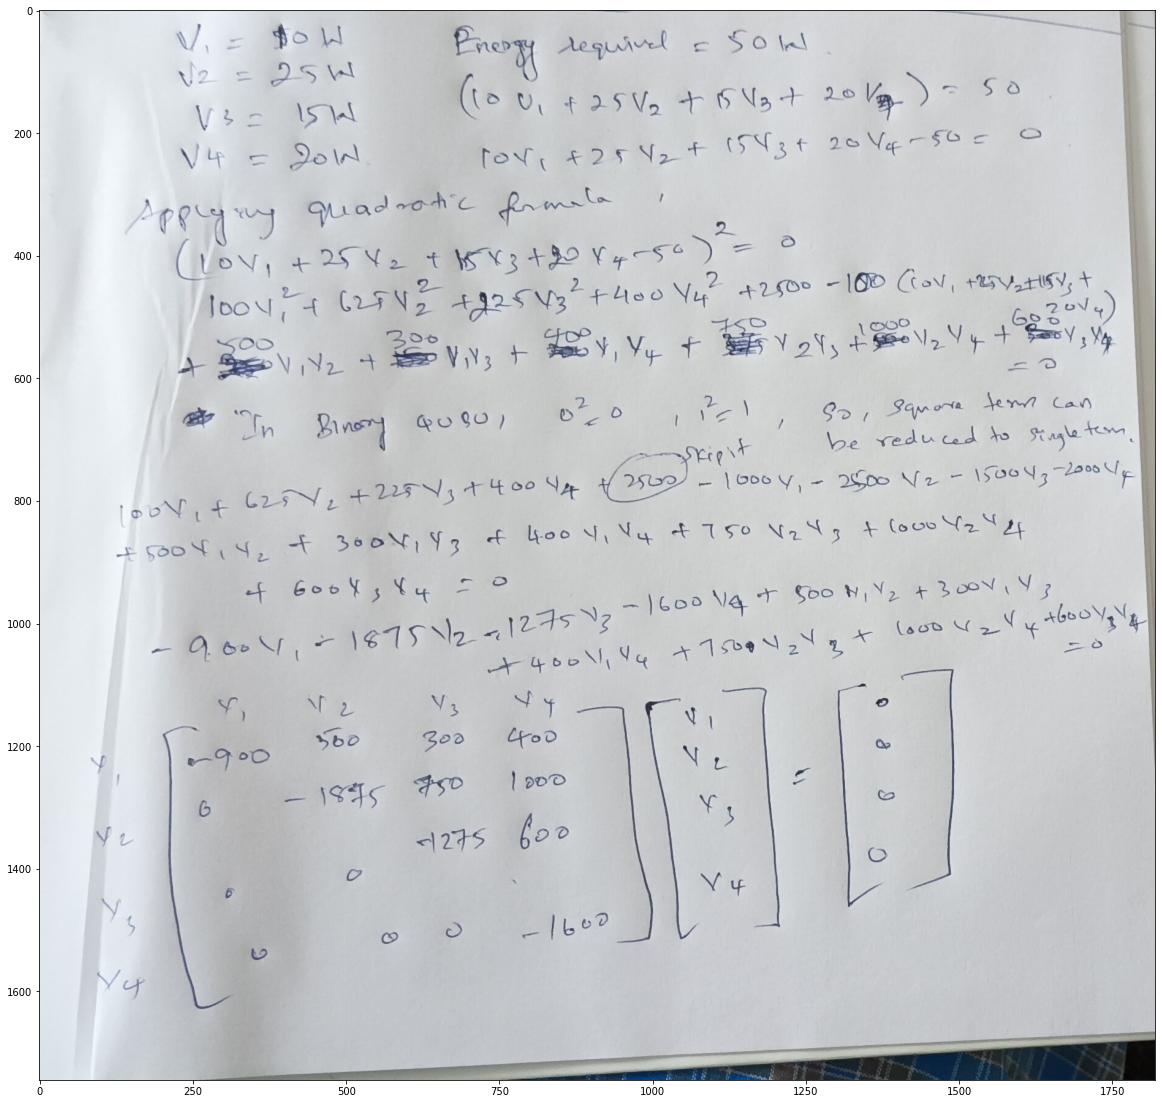

In [15]:
import matplotlib.pyplot as plt
img = plt.imread("D:\DeloiteProject\ProjectGIT\dinesh_project\FinalCopy\solution\pythonFiles\QUBOFormulationExample.jpg")
plt.figure(figsize=(20,20))
plt.imshow(img)

In [16]:
#computevehicleEnergyfromDischarging
#input is discharge vehicle list and the mall battery remaining capacity to be filled

from dwave.system import DWaveSampler, EmbeddingComposite
import dwave.inspector
from sympy import Symbol, Integer, Pow, symbols, expand
from matplotlib import pyplot
import numpy

import neal

def computeVehicleDischargingEnergy(vehicleData, mallBatteryEnergyNeeded):
    num_vehicles = len(vehicleData[0])
    num_slack_variables = 5#binary equaivalnet of 250(for 30 mins from 500(mall battery capacity per hour))

    x = symbols('x_0:%d' % num_vehicles)      # Define x_0 through x_n (no of vehicles).
    s = symbols('s_0:%d' % num_slack_variables)  # Define s_0 through s_n (no of binary digits from 500(mall battery capacity)).
    all_binary_variables = x + s                 # Used to check binary variables.
    
    #construct qubo -> sum of vehicles - required energy=0
    #convert to quadratic equation
    H = (mallBatteryEnergyNeeded + sum([
        int(vehicleData[1][i]) * x[i] for i in range(num_vehicles)
    ]) - 6*s[0] - 18*s[1] - 32*s[2] - 64*s[3] - 130*s[4])**2

    H = expand(H)

    qubo = {}

    for monomial in H.args:

        coefficient = None

        # The final dictionary will use tuples as keys, as Python dictionaries
        # require the keys to be immutable, but we will use lists until we have
        # clarified the final contents of each key.
        key = []

        for variable in monomial.args:
            # Linear terms - Simple binary variables.
            if isinstance(variable, Symbol) and variable in all_binary_variables:
                key.append(str(variable))

            # Squared binary variables. In QUBO's, x_i^2 == x_i.
            elif isinstance(variable, Pow) \
                    and variable.args[0] in all_binary_variables:
                key.append(str(variable.args[0]))

            # Constant coefficients.
            elif isinstance(variable, Integer):
                coefficient = variable

        if len(key) == 1:
            key = key + key
        key = tuple(key)

        if len(key) == 2:
            if key not in qubo:
                qubo[key] = float(coefficient)
            else:
                qubo[key] += float(coefficient)

    #If using sampler from library
    sampler = neal.SimulatedAnnealingSampler()
    
    #If using sampler from DWave hardware device
#     sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_6', token=''))
    num_reads = 5000

    response = sampler.sample_qubo(qubo, num_reads=num_reads)
    response = response.aggregate()
    
    embedding = response.info
#     print(embedding.values())
#     print(f"Number of logical variables: {len(embedding.keys())}")
#     print(f"Number of physical qubits used in embedding: {sum(len(chain) for chain in embedding.values())}")

    #response.data has minimum energy solutions at the top and we have to iterate and pick the best
    bestNumOccurence=-1
    bestVariableSet=[]
    for values, _, num_occurrences in response.data():
        variables = [key[2:] for key in values if values[key] != 0 and key[0]!='s']
#         if num_occurrences>bestNumOccurence:
#             bestNumOccurence=num_occurrences
#             bestVariableSet=[]
#             bestVariableSet=variables
        if len(variables)>bestNumOccurence:
            bestNumOccurence=len(variables)
            bestVariableSet=[]
            bestVariableSet=variables
#     print(bestVariableSet)
    return bestVariableSet

# Main algorithm:
Note: before run, please flush the data and read the data freshly for proper execution.

In [17]:
#optimisation for each interval
carbonCostWeekArr=[]
carbonCostDailyBasisArr=[]
plugPowerWeekArr=[]
plugPowerDailyBasisArr=[]
mallBatteryCurrentValue=0
for day in range(no_of_days_in_week):
    totalPlugPowerFortheDay=0
    totalCarbonCostForDay=0
    carbonCostDayArr=[]
    plugPowerDayArr=[]
#     print(' ----------------------------------------------------------------------------------------------- ')
#     print('Calculation done for ', days_List[day])
#     print(' --------------------------- ')
#     print('                             ')
    for timeindex in range(day_intervals):
        plugPowerNeeded=0
        carbonCost=0
#         print('                                         ')
#         print('     Calculation done for the time ', getTimeinHrMins(timeindex))
#         print('     -------------------------------------------- ')
#         print('                                         ')
#         print('          Currently available mall battery power is ', mallBatteryCurrentValue, ' KWh')
        #calculate mall consumption
        mallConsumption=getMallConsumption(timeindex, day)
#         print('          Mall Consumption is ', mallConsumption, ' KWh')
        
        #calculate solar power production
        solarPowerProdn=getSolarPowerEnergy(timeindex, day)
#         print('          Solar power production is ', solarPowerProdn, ' KWh')
        
        #get vehicle data to be charged and discharged in this interval
        vehicleData=getEligibleVehicles(timeindex, day)
#         print(vehicleData)
#         print('          No. of vehicles mandatorily to be charged is ', len(vehicleData[3]))
#         print('          No. of vehicles eligible to be discharged is ', len(vehicleData[0]))
        
        #vehicle charging is mandatory, so calculate the charging energy needed
        totalPowerNeededForChargingInKWh=0
        if len(vehicleData[3])>0:
#             print('          Charging Vehicle Summary ')
            for chargingVehicleIndex in range(len(vehicleData[3])):
                #sum up the charging power
                totalPowerNeededForChargingInKWh+=vehicleData[4][chargingVehicleIndex]
#                 print('               Vehicle ', vehicleData[3][chargingVehicleIndex], ' charged with ', vehicleData[4][chargingVehicleIndex], ' KWh')
                #since this is mandatorily charged, update back the vehicle charging ind to C to avoid duplicate charging
                car_data[int(vehicleData[5][chargingVehicleIndex])][7]='C'
#         else:
#             print('          No Vehicles are there to charge in this interval')
#         print('          Total power needed for charging vehicles is ', totalPowerNeededForChargingInKWh, ' KWh')
        
        #calculate the remaining power needed from discharging
        #If mall battery has surplous power to meet mall consumption and charging, then no need to go for discharging power
        #currentPowerAvl = existing_battery_power + solarPower - mallConsumption -vehicleChargingEnergy
        currentPowerAvl = mallBatteryCurrentValue + solarPowerProdn - mallConsumption - totalPowerNeededForChargingInKWh
#         print('          Current power available [(Mall Battery Existing Value) + (Solar production) - (Mall Consumption) - (Vehicle charging)] is ', currentPowerAvl, ' KWh')
        dischargingVehiclePower=0
        #if after all expenses, we have power remaining then we are going to save in battery.
        if currentPowerAvl>0:
            #if energy we have currently is greater than mall battery capacity, then store the max battery capactity
            #this block means after consumption, we have extra power to save
            #so the mall battery capacity is non zero
            if currentPowerAvl>=mallBatteryCapacity_KWh:
                mallBatteryCurrentValue=mallBatteryCapacity_KWh
#                 print('          Currently power available is greater than or equal to ',mallBatteryCapacity_KWh,' KWh and is enough to meet mall battery storage, so no discharging power needed')
            else:
                #if mall battery is not full, for the remaining energy we apply optimisation
#                 print('          Currently power available is lesser than ',mallBatteryCapacity_KWh,' KWh but greater than 0, so this excess energy can be saved in mall battery. But the remaining battery energy needed is computed from the discharge power of the vehicles.')
                maximumDischargeEnergyNeeded = mallBatteryCapacity_KWh - currentPowerAvl
#                 print('          So we will try to get maximum enery ',maximumDischargeEnergyNeeded,' KWh from the optimised discharge power of the vehicles.')
                if len(vehicleData[1])==0:
#                     print('          Discharging vehicle size is 0, hence 0 discharging power. So, currently available power is stored in the mall battery')
                    mallBatteryCurrentValue=currentPowerAvl
                elif len(vehicleData[1])>0:
                    eligibleVehiclesForDischarge=computeVehicleDischargingEnergy(vehicleData, maximumDischargeEnergyNeeded)
#                     print('          Discharge Vehicle Summary ')
                    for dischargeVehicleIndex in eligibleVehiclesForDischarge:
                        dischargingVehiclePower+=vehicleData[1][int(dischargeVehicleIndex)]
#                         print('               Vehicle ', vehicleData[0][int(dischargeVehicleIndex)], ' discharged power of ', abs(vehicleData[1][int(dischargeVehicleIndex)]), ' KWh')
                        car_data[int(vehicleData[2][int(dischargeVehicleIndex)])][6]='D'
#                     print('          Total power obtained from discharging vehicles is ', abs(dischargingVehiclePower), ' KWh')
#                     print('          So discharge vehicle power and currently available power both of ',currentPowerAvl+abs(dischargingVehiclePower),' KWh is saved in the mall battery which doesnt exceed mall battery capacity of ',mallBatteryCapacity_KWh, ' KWh')
                    mallBatteryCurrentValue=currentPowerAvl + abs(dischargingVehiclePower)
        elif currentPowerAvl<=0:
            #this block is for when the consumed energy is greater than we have, so we have to depend in discharging power or soalr power
            #means we have less energy than the consumption needed, so we are dependent on other sources of energy
            #so mall battery capacity is 0 and is fully utilised.
#             print('          Currently power available is less than or equal to 0, so we will check discharging power needed as mall battery power is fully exhausted')
            mallBatteryCurrentValue=0
            if len(vehicleData[1])==0:
                #if no vehicles available, then we directly go to plug power
#                 print('          Discharging vehicle size is 0, hence 0 discharging power and we need to look for plug power')
                plugPowerNeeded=abs(currentPowerAvl)
                totalPlugPowerFortheDay+=plugPowerNeeded
            elif len(vehicleData[1])>0:
                #we have discharging vehicles list and we are going to do optimisation
                remainingenergyNeeded = mallBatteryCapacity_KWh - currentPowerAvl
#                 print('          Discharging vehicle size is not 0, hence we will calculate optimised discharging power using QUBO through DWave for the remaining energy needed ', remainingenergyNeeded, ' KWh')
                #call the optimisation function to get the optimised vehicles to discharge power
                eligibleVehiclesForDischarge=computeVehicleDischargingEnergy(vehicleData, remainingenergyNeeded)
#                 print('          Discharge Vehicle Summary ')
                #display disharge vehicle summary and sum up the discharge power
                for dischargeVehicleIndex in eligibleVehiclesForDischarge:
                    dischargingVehiclePower+=vehicleData[1][int(dischargeVehicleIndex)]
#                     print('               Vehicle ', vehicleData[0][int(dischargeVehicleIndex)], ' discharged power of ', abs(vehicleData[1][int(dischargeVehicleIndex)]), ' KWh')
                    car_data[int(vehicleData[2][int(dischargeVehicleIndex)])][6]='D'
#                 print('          Total power obtained from discharging vehicles is ', abs(dischargingVehiclePower), ' KWh')
                if dischargingVehiclePower>abs(currentPowerAvl):
                    #if discharge power is greater than needed energy, then we take the max energy needed
#                     print('          Discharge Vehicle Power is greater than the current power needed, so utilising the energy, the remaining energy is saved in the mall battery and no plug power needed')
                    mallBatteryCurrentValue = dischargingVehiclePower + currentPowerAvl
                elif dischargingVehiclePower<abs(currentPowerAvl):
                    #if discharging power is not enough, we go for the plug power for the remaining energy needed.
#                     print('          Discharge Vehicle Power is less than the current power needed, so the difference energy of ',abs(currentPowerAvl)-dischargingVehiclePower,' KWh is used from the plug power')
                    mallBatteryCurrentValue = 0
                    plugPowerNeeded=abs(currentPowerAvl)-dischargingVehiclePower
                    totalPlugPowerFortheDay+=plugPowerNeeded
        carbonCost=plugPowerNeeded*plugPowerCarbonCost + dischargingVehiclePower*vehicleDischargingCarbonCost + totalPowerNeededForChargingInKWh*vehicleChargingCarbonCost
        totalCarbonCostForDay+=carbonCost
        carbonCostDayArr.append(carbonCost)
        plugPowerDayArr.append(plugPowerNeeded)
#         print('          After all calculations, current Battery storage value is ', mallBatteryCurrentValue, ' KWh')
#         print('          Plug Power needed for ', days_List[day], ' time ', getTimeinHrMins(timeindex), ' is ', plugPowerNeeded, ' KWh')
        if mallBatteryCurrentValue > mallBatteryCapacity_KWh:
            mallBatteryCurrentValue=mallBatteryCapacity_KWh
#             print('          Mall battery value is exceeding battery capacity, so limiting to the battery capacity ', mallBatteryCurrentValue, ' KWh')
#         print('     ----------------------------------- ')
    carbonCostDailyBasisArr.append(carbonCostDayArr)
    plugPowerDailyBasisArr.append(plugPowerDayArr)
    carbonCostWeekArr.append(totalCarbonCostForDay)
    plugPowerWeekArr.append(totalPlugPowerFortheDay)
#     print('     Total Plug Power needed for ', days_List[day], ' time ', getTimeinHrMins(timeindex), ' is ', totalPlugPowerFortheDay, ' KWh')
#     print(' ----------------------------------------------------------------------------------------------- ')

Sample output is <br>
 -----------------------------------------------------------------------------------------------<br> 
Calculation done for  Monday<br>
 --------------------------- <br>                           
<br>                                         
     Calculation done for the time  00:00<br>
     -------------------------------------------- <br>
<br>                                         
          Currently available mall battery power is  0  KWh<br>
          Mall Consumption is  12  KWh<br>
          Solar power production is  0  KWh<br>
[[], [], [], [], [], []]<br>
          No. of vehicles mandatorily to be charged is  0<br>
          No. of vehicles eligible to be discharged is  0<br>
          No Vehicles are there to charge in this interval<br>
          Total power needed for charging vehicles is  0  KWh<br>
          Current power available [(Mall Battery Existing Value) + (Solar production) - (Mall Consumption) - (Vehicle charging)] is  -12  KWh<br>
          Currently power available is less than or equal to 0, so we will check discharging power needed as mall battery power is fully exhausted<br>
          Discharging vehicle size is 0, hence 0 discharging power and we need to look for plug power<br>
          After all calculations, current Battery storage value is  0  KWh<br>
          Plug Power needed for  Monday  time  00:00  is  12  KWh<br>

The below records the carbon cost every 30 mins

In [1]:
#carbonCostDailyBasisArr

The below records the plug power for every 30 mins

In [2]:
#plugPowerDailyBasisArr

The below records the carbon cost on daily basis for the week

In [3]:
#carbonCostWeekArr

The below records the plug power on daily basis for the week

In [4]:
#plugPowerWeekArr

Below is the updated car data list. <br>
['N','N'] -> The vehicle didnt participated in either discharging or charging<br>
<br>
['N','C'] -> The vehicle didnt participated in discharging but participated in charging<br>
<br>
['D','N'] -> The vehicle participated in discharging but not in charging<br>
<br>
['D','C'] -> The vehicle participated in both discharging or charging<br>

In [5]:
#car_data

sample output after processing will be: <br>
some are no discharging, no charging - 'N', 'N' <br>
some have discharging, no charging - 'D', 'N' <br>
some are no discharging, but have charging - 'N', 'C' <br>
some have both discharging and charging - 'D', 'C' <br>
<br>
[['Mo1', 'Monday', '8:00', '92', '8:00', '53', 'N', 'N'], <br>
 ['Mo2', 'Monday', '8:00', '73', '8:30', '42', 'D', 'N'], <br>
 ['Mo3', 'Monday', '8:00', '73', '9:00', '67', 'D', 'C'], <br>
 ['Mo16', 'Monday', '8:30', '77', '9:00', '79', 'N', 'C']] <br>

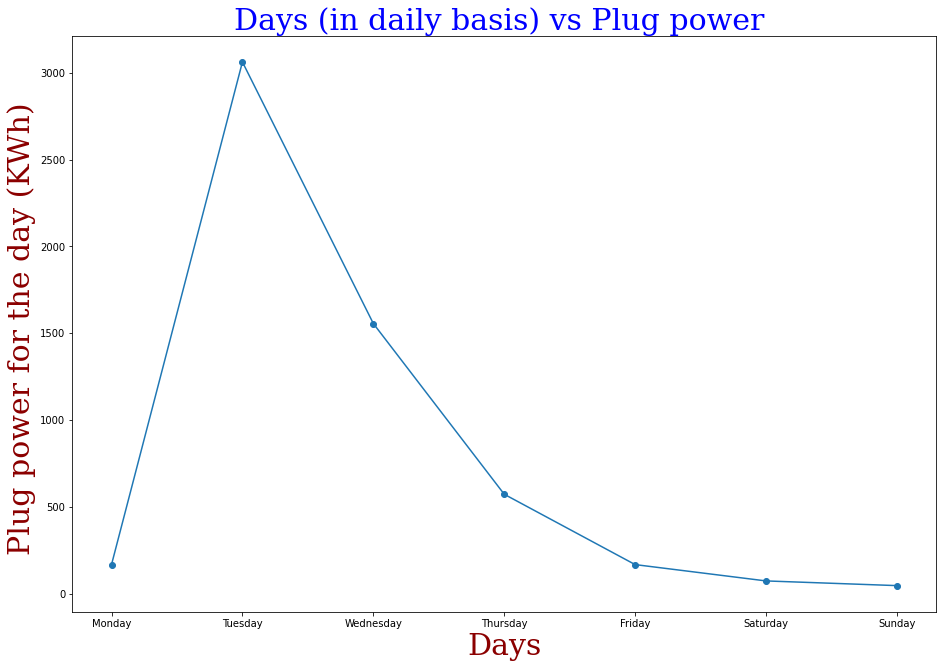

In [51]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(days_List)
y1 = np.array(plugPowerWeekArr)

font1 = {'family':'serif','color':'blue','size':30}
font2 = {'family':'serif','color':'darkred','size':30}

fig,ax = plt.subplots()
ax = fig.add_axes([0,0,2,2])
plt.plot(x, y1, marker="o")

plt.xlabel("Days")
plt.ylabel("Plug power for the day")

plt.xlabel("Days", fontdict = font2)
plt.ylabel("Plug power for the day (KWh) ", fontdict = font2)
plt.title('Days (in daily basis) vs Plug power ', fontdict = font1)
plt.show()

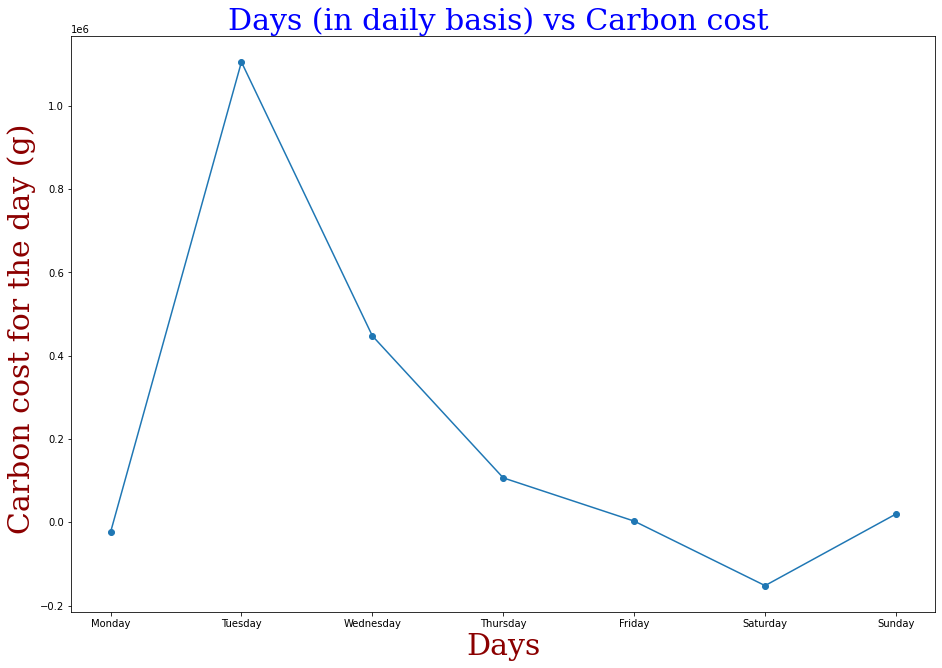

In [52]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(days_List)
y1 = np.array(carbonCostWeekArr)

fig,ax = plt.subplots()
ax = fig.add_axes([0,0,2,2])

font1 = {'family':'serif','color':'blue','size':30}
font2 = {'family':'serif','color':'darkred','size':30}

plt.plot(x, y1, marker="o")

plt.xlabel("Days")
plt.ylabel("Carbon cost for the day")

plt.xlabel("Days", fontdict = font2)
plt.ylabel("Carbon cost for the day (g) ", fontdict = font2)
plt.title('Days (in daily basis) vs Carbon cost ', fontdict = font1)
plt.show()

In [53]:
x=[]
for i in range(48):
    x.append(getTimeinHrMins(i))
print(x)

['00:00', '00:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00', '4:30', '5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30', '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00', '23:30']


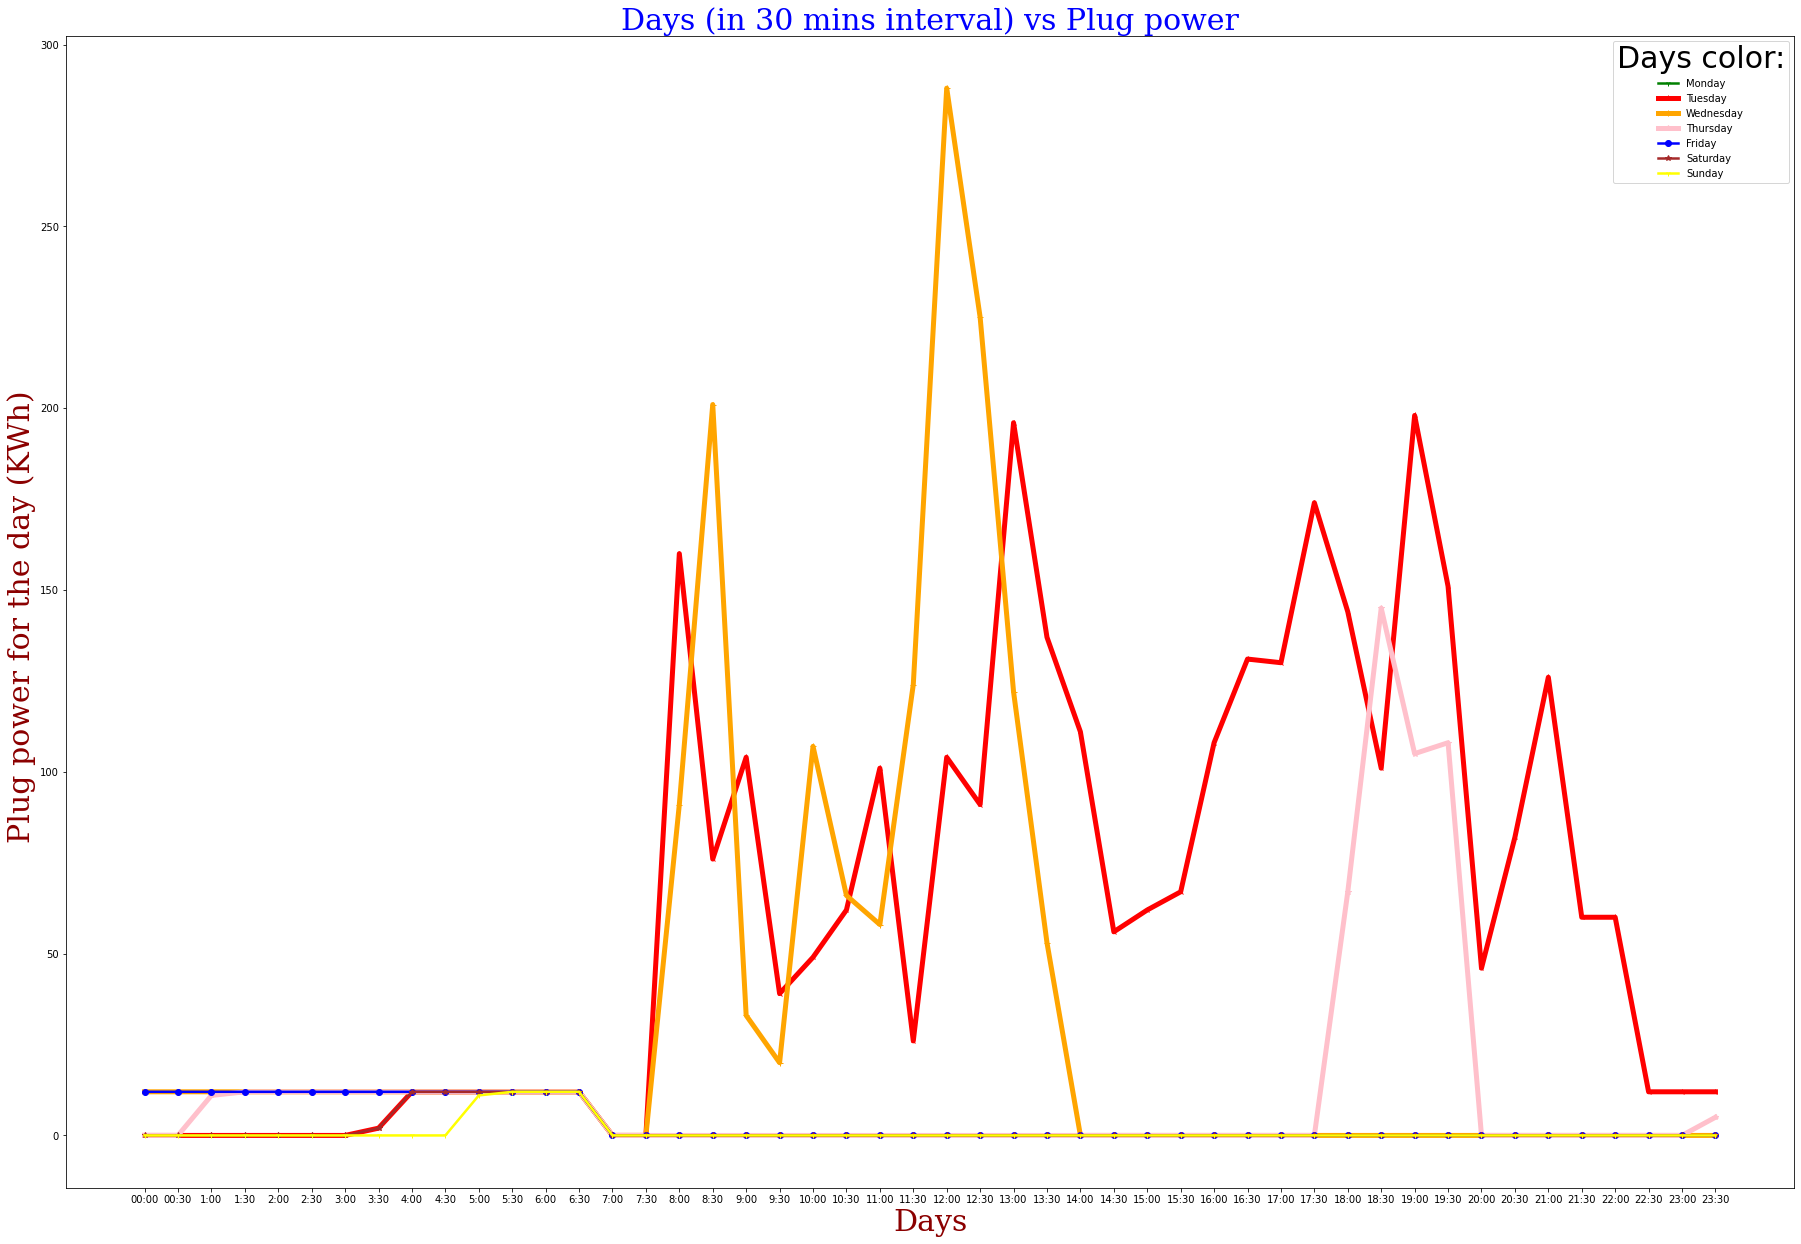

In [54]:
import numpy as np
import matplotlib.pyplot as plt

y0 = np.array(plugPowerDailyBasisArr[0])
y1 = np.array(plugPowerDailyBasisArr[1])
y2 = np.array(plugPowerDailyBasisArr[2])
y3 = np.array(plugPowerDailyBasisArr[3])
y4 = np.array(plugPowerDailyBasisArr[4])
y5 = np.array(plugPowerDailyBasisArr[5])
y6 = np.array(plugPowerDailyBasisArr[6])

fig,ax = plt.subplots()
ax = fig.add_axes([0,0,4,4])

font1 = {'family':'serif','color':'blue','size':30}
font2 = {'family':'serif','color':'darkred','size':30}

plt.plot(x, y0, marker="1", label='Monday', color='green', linewidth = '2.5')
plt.plot(x, y1, marker="2", label='Tuesday', linewidth = '5', color='r')
plt.plot(x, y2, marker="+", label='Wednesday', linewidth = '5', color='orange')
plt.plot(x, y3, marker="*", label='Thursday', linewidth = '5', color='pink')
plt.plot(x, y4, marker="o", label='Friday', color='blue', linewidth = '2.5')
plt.plot(x, y5, marker="*", label='Saturday', color='brown', linewidth = '2.5')
plt.plot(x, y6, marker="1", label='Sunday', color='yellow', linewidth = '2.5')

plt.xlabel("Days", fontdict = font2)
plt.ylabel("Plug power for the day (KWh) ", fontdict = font2)
plt.legend(title='Days color:', title_fontsize = 30)
plt.title('Days (in 30 mins interval) vs Plug power', fontdict = font1)
plt.show()

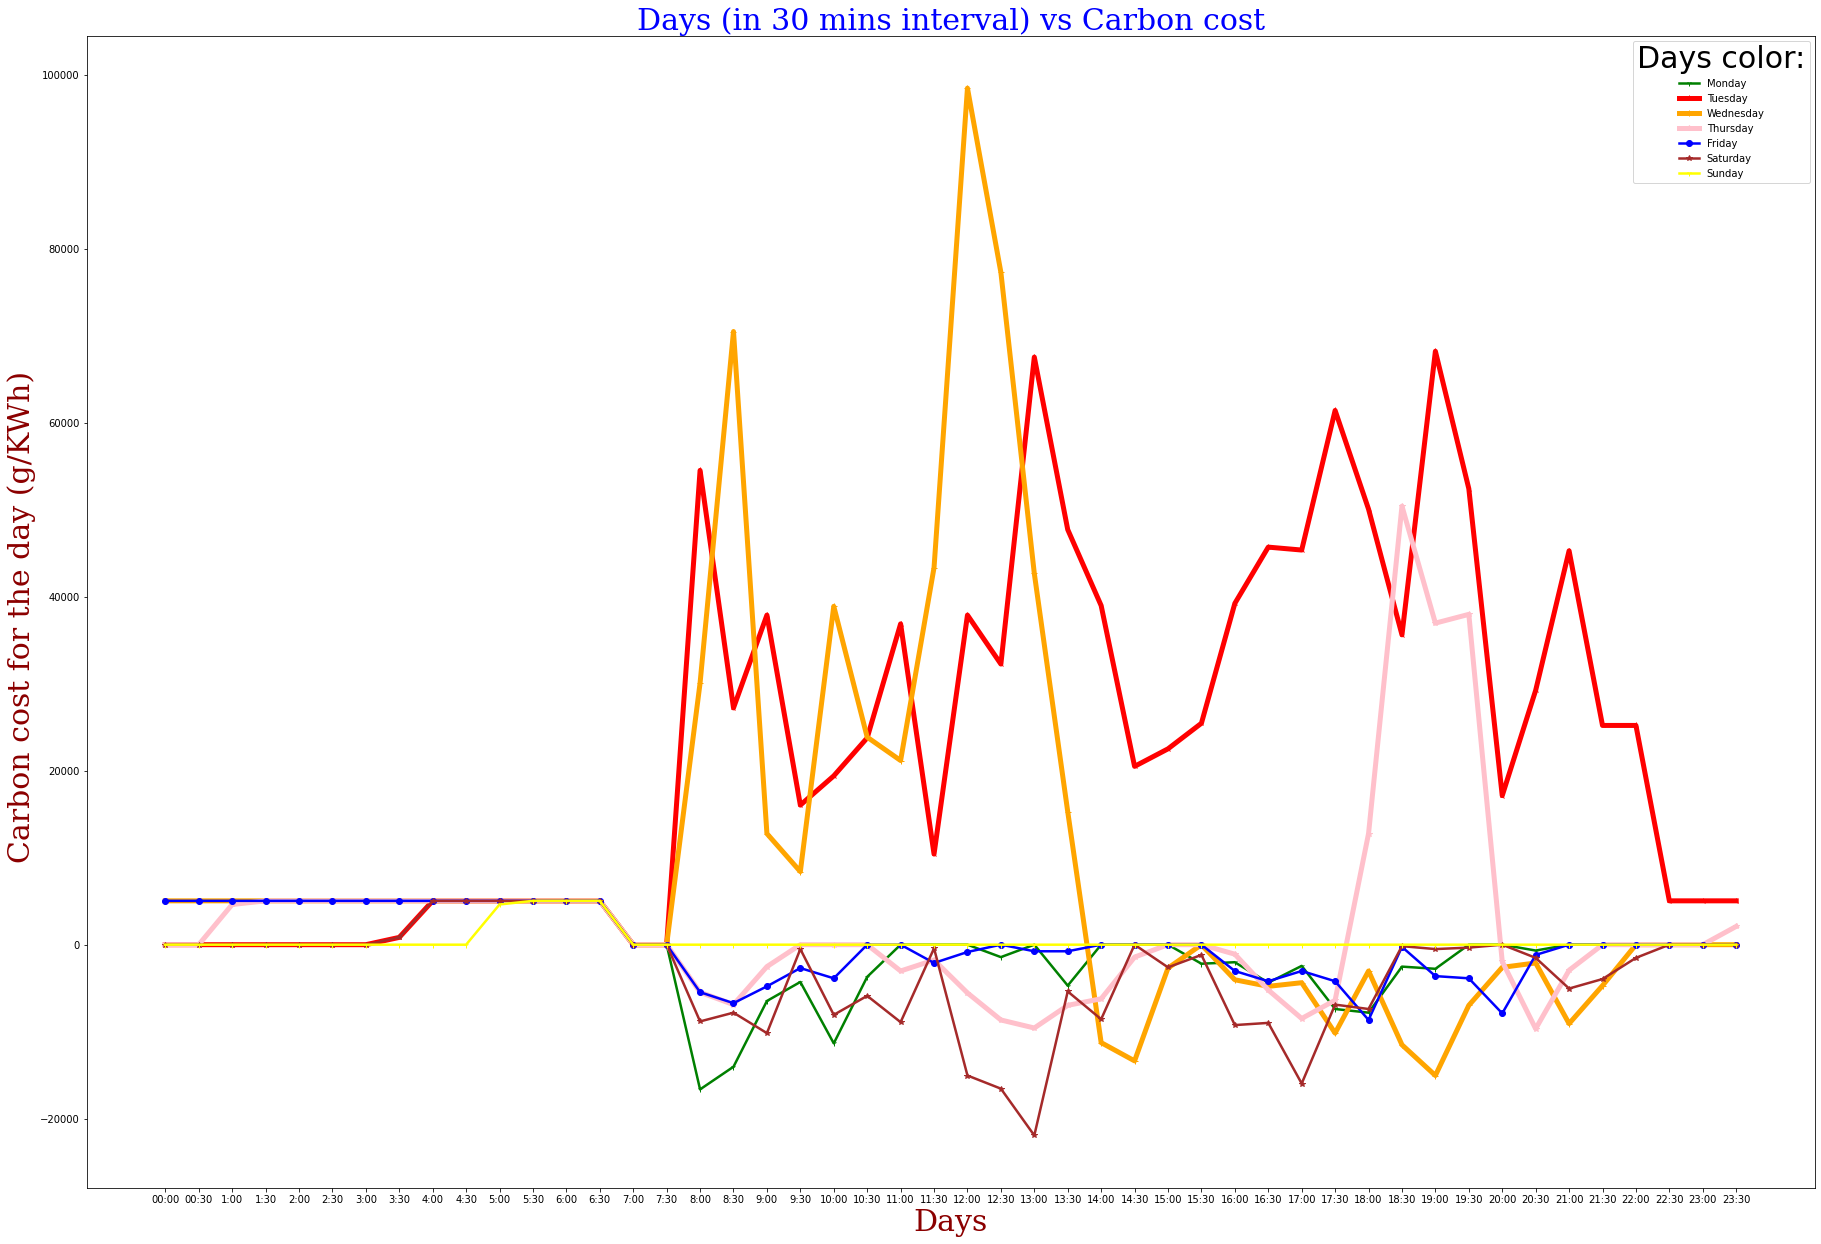

In [55]:
import numpy as np
import matplotlib.pyplot as plt

y0 = np.array(carbonCostDailyBasisArr[0])
y1 = np.array(carbonCostDailyBasisArr[1])
y2 = np.array(carbonCostDailyBasisArr[2])
y3 = np.array(carbonCostDailyBasisArr[3])
y4 = np.array(carbonCostDailyBasisArr[4])
y5 = np.array(carbonCostDailyBasisArr[5])
y6 = np.array(carbonCostDailyBasisArr[6])

fig,ax = plt.subplots()
ax = fig.add_axes([0,0,4,4])

font1 = {'family':'serif','color':'blue','size':30}
font2 = {'family':'serif','color':'darkred','size':30}

plt.plot(x, y0, marker="1", label='Monday', color='green', linewidth = '2.5')
plt.plot(x, y1, marker="2", label='Tuesday', linewidth = '5', color='r')
plt.plot(x, y2, marker="+", label='Wednesday', linewidth = '5', color='orange')
plt.plot(x, y3, marker="*", label='Thursday', linewidth = '5', color='pink')
plt.plot(x, y4, marker="o", label='Friday', color='blue', linewidth = '2.5')
plt.plot(x, y5, marker="*", label='Saturday', color='brown', linewidth = '2.5')
plt.plot(x, y6, marker="1", label='Sunday', color='yellow', linewidth = '2.5')

plt.xlabel("Days", fontdict = font2)
plt.ylabel("Carbon cost for the day (g/KWh) ", fontdict = font2)
plt.legend(title='Days color:', title_fontsize = 30)
plt.title('Days (in 30 mins interval) vs Carbon cost', fontdict = font1)
plt.show()

From the above plot, we see, only few days use plug power during the early morning rest hours. <br>
Few days use the remaining battery power from mall of the previous day to use it in current day early morning rest hours.<br>
Also, for tuesday and wednesday only use the plug during early active hours.<br>
Tuesday and thursday use the plug power in the evening active hours.<br>
For all other days, the graph shows carbon cost below 0.<br>
It means instead of plug power, it is able to utlise from the solar power and the discharging battery power.<br>